In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import data

In [2]:
datafolder = 'data/'

In [3]:
addr_clust = pd.read_csv(datafolder + 'address_clust.csv')
addr_stats = pd.read_csv(datafolder + 'address_stats.csv')

# A quick look

In [4]:
addr_clust.head(2)

,address_id,cluster_id
0,71413451,1
1,71411914,1


In [5]:
addr_stats.head()

,id,address_id,transaction_id,received,sent
0,87134765,46402336,19162323,0.0,1800000.0
1,87134766,45919235,19162323,0.0,1071052.0
2,87134767,46529090,19162323,1000000.0,0.0
3,87134768,46529091,19162323,1821052.0,0.0
4,87154706,46529090,19166856,0.0,1000000.0


# Join datasets

In [6]:
addr_stats = addr_stats.set_index('address_id')
addr_clust = addr_clust.set_index('address_id')

In [7]:
data = addr_stats.join(addr_clust).reset_index()

In [8]:
data.head()

,address_id,id,transaction_id,received,sent,cluster_id
0,821475,133545303,28938349,0.0,2.000000e+06,NaN
1,821475,133546419,28938602,5500.0,0.000000e+00,NaN
2,2275432,88229621,19396141,0.0,6.400000e+03,NaN
3,5985476,95086880,20876844,0.0,1.859900e+09,NaN
4,5985476,95124520,20885474,0.0,1.900000e+09,NaN


In [9]:
data.cluster_id = data.cluster_id.fillna(0) # set 0 as outer cluster id

In [10]:
data.head()

,address_id,id,transaction_id,received,sent,cluster_id
0,821475,133545303,28938349,0.0,2.000000e+06,0.0
1,821475,133546419,28938602,5500.0,0.000000e+00,0.0
2,2275432,88229621,19396141,0.0,6.400000e+03,0.0
3,5985476,95086880,20876844,0.0,1.859900e+09,0.0
4,5985476,95124520,20885474,0.0,1.900000e+09,0.0


In [11]:
data.cluster_id = data.cluster_id.astype('int')

In [12]:
data.head(2)

,address_id,id,transaction_id,received,sent,cluster_id
0,821475,133545303,28938349,0.0,2000000.0,0
1,821475,133546419,28938602,5500.0,0.0,0


In [13]:
# np.any(data.sent - data.sent.astype('long') != 0)

# np.any(data.received - data.received.astype('long') != 0)

# data.received = data.received.astype('long')
# data.sent = data.sent.astype('long')

# Get unique transaction ids

In [14]:
transactions = set(data.transaction_id.values)

# Functions defenition

In [15]:
def init_df():
    z = np.zeros((3,4))
    df = pd.DataFrame(z, columns=['0', '1', '2', 'fee'])
    return df

In [16]:
def transaction_info_df(df, transaction_id):
    info = init_df() # dict which will be returned
    subset = df[df.transaction_id == transaction_id] 
    sender = int(subset.cluster_id[subset.sent != 0].iloc[0])
    
    for _, row in subset.iterrows():
        if row.sent == 0:
            info.iloc[sender, int(row.cluster_id)] += row.received
    
    fee = subset.sent.sum() - subset.received.sum() # transaction fee
    info.iloc[sender, 3] += fee
    
    return info

# Calculate transactions sums

In [17]:
def calc_result():
    result_df = init_df()
    for t in transactions:
        result_df += transaction_info_df(data, t)
    return result_df

In [18]:
result = calc_result()

In [19]:
# convert satoshi to bitcoins
result_bitcoins = result / 10**8

In [20]:
result_bitcoins.index.name = 'sender'

In [21]:
result_bitcoins

,0,1,2,fee
sender,,,,
0,722.751892,297.119684,9.740139,0.951604
1,300.553929,209.800509,129.243240,0.667144
2,4.869840,135.820000,889.807246,0.745667


## Shallow validation

In [25]:
data.sent.sum() / 10**8

2702.07089296

In [31]:
np.sum(result_bitcoins.values, )

2702.07089296

# Plot results

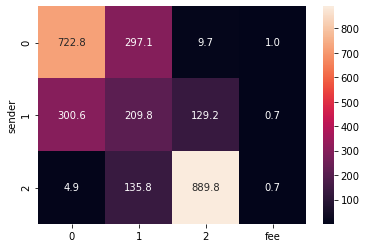

In [22]:
plt.xlabel('receiver')
plt.ylabel('sender')
sns.heatmap(result_bitcoins, annot=True, fmt='.1f')
plt.show()

## Let's hide unnecessary values

In [32]:
def plot_results(dataframe, title):
    # create mask to heatmap to hide transactions inside clusters:
    mask = np.zeros_like(dataframe).flatten()
    mask[::5] = 1
    mask = mask.reshape((3,-1))
    
    fontsize = 14
    plt.figure(figsize=(8,6))
    sns.heatmap(dataframe, annot=True, fmt='.1f', mask=mask)
    plt.xlabel('receiver', fontsize=fontsize)
    plt.ylabel('sender', fontsize=fontsize)
    plt.title(title)
    plt.show()

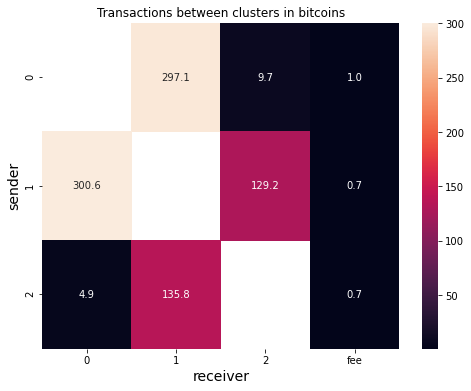

In [33]:
plot_results(result_bitcoins, 'Transactions between clusters in bitcoins')